In [1]:
import os

In [2]:
data_dir = '../../Downloads/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [5]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [6]:
print(len(lines))

420551


In [7]:
import pandas as pd

In [8]:
data = pd.read_csv(fname)

In [21]:
data.axes[1].get_values().shape

(15,)

In [24]:
data.get_values().shape

(420551, 15)

In [25]:
import numpy as np

In [26]:
float_data = np.zeros(( len(lines), len(header) - 1 ))

In [27]:
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [28]:
import matplotlib.pyplot as plt

In [31]:
%matplotlib inline

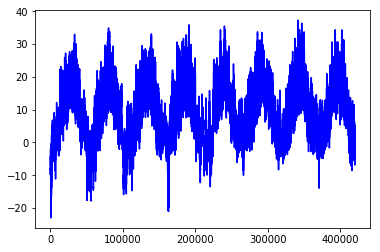

In [38]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp, 'b')

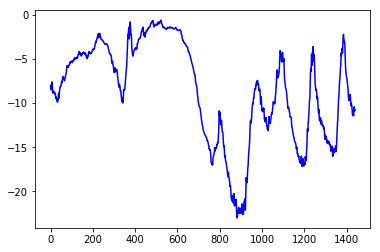

In [37]:
temp = float_data[:, 1]
plt.plot(range(1440), temp[:1440], 'b')

Normalise the data

In [39]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [48]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), 
                            lookback // step, 
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [49]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [50]:
train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

In [51]:
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

In [52]:
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

In [53]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [54]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [55]:
evaluate_naive_method()

0.2897359729905486


In [56]:
celsius_mae = 0.29 * std[1]

In [58]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

In [59]:
model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [60]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 15s - loss: 1.2993 - val_loss: 0.8456
Epoch 2/20
500/500 [==============================] - 14s - loss: 0.4055 - val_loss: 0.3251
Epoch 3/20
500/500 [==============================] - 15s - loss: 0.2845 - val_loss: 0.3246
Epoch 4/20
500/500 [==============================] - 11s - loss: 0.2629 - val_loss: 0.3169
Epoch 5/20
500/500 [==============================] - 12s - loss: 0.2524 - val_loss: 0.3595
Epoch 6/20
500/500 [==============================] - 12s - loss: 0.2418 - val_loss: 0.3038
Epoch 7/20
500/500 [==============================] - 13s - loss: 0.2361 - val_loss: 0.3200
Epoch 8/20
500/500 [==============================] - 11s - loss: 0.2321 - val_loss: 0.3285
Epoch 9/20
500/500 [==============================] - 11s - loss: 0.2262 - val_loss: 0.3214
Epoch 10/20
500/500 [==============================] - 12s - loss: 0.2218 - val_loss: 0.3216
Epoch 11/20
500/500 [==============================] - 11s - loss: 0.2186 - val

In [62]:
loss, val_loss = pd.Series(history.history)

In [63]:
epochs = range(1, len(loss) + 1)

In [64]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

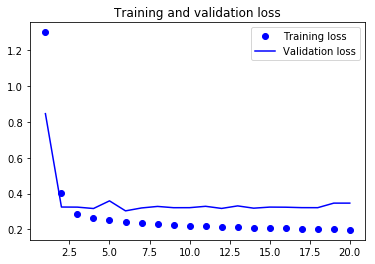

In [66]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

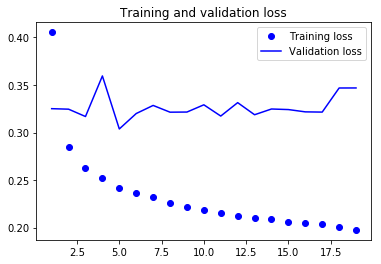

In [67]:
plt.plot(range(1, len(loss[1:]) + 1), loss[1:], 'bo', label='Training loss')
plt.plot(range(1, len(loss[1:]) + 1), val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
from keras.layers import GRU

In [69]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

In [70]:
model.compile(optimizer=RMSprop(), loss='mae')
history2 = model.fit_generator(train_gen, 
                               steps_per_epoch=500, 
                               epochs=20, 
                               validation_data=val_gen, 
                               validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 237s - loss: 0.2992 - val_loss: 0.2746
Epoch 2/20
500/500 [==============================] - 234s - loss: 0.2834 - val_loss: 0.2686
Epoch 3/20
500/500 [==============================] - 214s - loss: 0.2773 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 218s - loss: 0.2736 - val_loss: 0.2708
Epoch 5/20
500/500 [==============================] - 215s - loss: 0.2679 - val_loss: 0.2673
Epoch 6/20
500/500 [==============================] - 216s - loss: 0.2634 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 213s - loss: 0.2583 - val_loss: 0.2627
Epoch 8/20
500/500 [==============================] - 218s - loss: 0.2534 - val_loss: 0.2691
Epoch 9/20
500/500 [==============================] - 213s - loss: 0.2483 - val_loss: 0.2735
Epoch 10/20
500/500 [==============================] - 213s - loss: 0.2436 - val_loss: 0.2712
Epoch 11/20
500/500 [==============================] - 214s - loss: 0

In [71]:
loss, val_loss = pd.Series(history2.history)

In [72]:
epochs = range(1, len(loss) + 1)

In [73]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

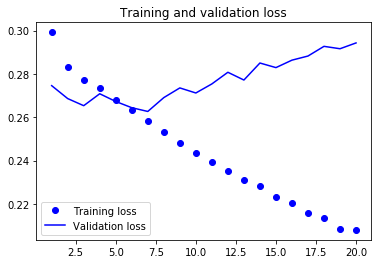

In [74]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [76]:
model = Sequential()
model.add(GRU(32, 
              dropout=0.2, 
              recurrent_dropout=0.2,
              input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

In [77]:
model.compile(optimizer=RMSprop(), loss='mae')
history3 = model.fit_generator(train_gen, 
                               steps_per_epoch=500, 
                               epochs=40, 
                               validation_data=val_gen, 
                               validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 227s - loss: 0.3434 - val_loss: 0.2757
Epoch 2/40
500/500 [==============================] - 225s - loss: 0.3146 - val_loss: 0.2763
Epoch 3/40
500/500 [==============================] - 226s - loss: 0.3093 - val_loss: 0.2730
Epoch 4/40
500/500 [==============================] - 226s - loss: 0.3068 - val_loss: 0.2746
Epoch 5/40
500/500 [==============================] - 226s - loss: 0.3013 - val_loss: 0.2729
Epoch 6/40
500/500 [==============================] - 226s - loss: 0.2994 - val_loss: 0.2716
Epoch 7/40
500/500 [==============================] - 225s - loss: 0.2967 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 224s - loss: 0.2947 - val_loss: 0.2658
Epoch 9/40
500/500 [==============================] - 226s - loss: 0.2942 - val_loss: 0.2644
Epoch 10/40
500/500 [==============================] - 225s - loss: 0.2913 - val_loss: 0.2719
Epoch 11/40
500/500 [==============================] - 227s - loss: 0

In [78]:
loss, val_loss = pd.Series(history3.history)

In [79]:
epochs = range(1, len(loss) + 1)

In [80]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

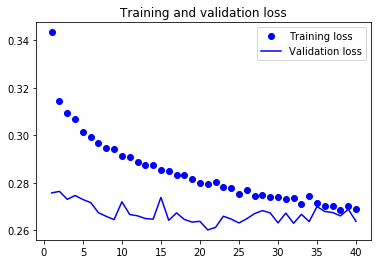

In [81]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
model = Sequential()
model.add(GRU(32, 
              dropout=0.1, 
              recurrent_dropout=0.5,
              return_sequences=True,
              input_shape=(None, float_data.shape[-1])))
model.add(GRU(64, activation='relu', 
              dropout=0.1, 
              recurrent_dropout=0.5))
model.add(Dense(1))

In [83]:
model.compile(optimizer=RMSprop(), loss='mae')
history4 = model.fit_generator(train_gen, 
                               steps_per_epoch=500, 
                               epochs=40, 
                               validation_data=val_gen, 
                               validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 406s - loss: 0.3329 - val_loss: 0.2808
Epoch 2/40
500/500 [==============================] - 404s - loss: 0.3119 - val_loss: 0.2772
Epoch 3/40
500/500 [==============================] - 404s - loss: 0.3062 - val_loss: 0.2698
Epoch 4/40
500/500 [==============================] - 401s - loss: 0.3031 - val_loss: 0.2692
Epoch 5/40
500/500 [==============================] - 401s - loss: 0.3000 - val_loss: 0.2714
Epoch 6/40
500/500 [==============================] - 400s - loss: 0.2953 - val_loss: 0.2685
Epoch 7/40
500/500 [==============================] - 401s - loss: 0.2917 - val_loss: 0.2757
Epoch 8/40
500/500 [==============================] - 401s - loss: 0.2889 - val_loss: 0.2682
Epoch 9/40
500/500 [==============================] - 402s - loss: 0.2873 - val_loss: 0.2664
Epoch 10/40
500/500 [==============================] - 402s - loss: 0.2857 - val_loss: 0.2672
Epoch 11/40
500/500 [==============================] - 399s - loss: 0

KeyboardInterrupt: 

In [78]:
loss, val_loss = pd.Series(history4.history)

In [79]:
epochs = range(1, len(loss) + 1)

In [80]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

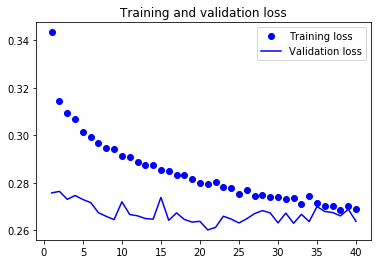

In [81]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Training and evaluating an LSTM using reversed sequences

In [84]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [85]:
max_features = 10000
maxlen = 500

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=max_features)

Reverse sequences

In [86]:
train_data = [x[::-1] for x in train_data]
test_data = [x[::-1] for x in test_data]

In [87]:
train_data = sequence.pad_sequences(train_data, maxlen=maxlen)
test_data = sequence.pad_sequences(test_data, maxlen=maxlen)

In [88]:
from keras.layers import Embedding

In [89]:
from keras.layers import LSTM

In [90]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [92]:
history5 = model.fit(train_data, train_labels, 
                     epochs=10, batch_size=512, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 35s - loss: 0.5215 - acc: 0.7652 - val_loss: 0.4062 - val_acc: 0.8366
Epoch 2/10
20000/20000 [==============================] - 35s - loss: 0.3638 - acc: 0.8542 - val_loss: 0.5448 - val_acc: 0.7438
Epoch 3/10
20000/20000 [==============================] - 35s - loss: 0.3027 - acc: 0.8825 - val_loss: 0.3244 - val_acc: 0.8730
Epoch 4/10
20000/20000 [==============================] - 34s - loss: 0.2605 - acc: 0.9013 - val_loss: 0.4319 - val_acc: 0.8442
Epoch 5/10
20000/20000 [==============================] - 35s - loss: 0.2312 - acc: 0.9131 - val_loss: 0.3315 - val_acc: 0.8842
Epoch 6/10
20000/20000 [==============================] - 34s - loss: 0.2146 - acc: 0.9218 - val_loss: 0.3669 - val_acc: 0.8412
Epoch 7/10
20000/20000 [==============================] - 35s - loss: 0.1951 - acc: 0.9286 - val_loss: 0.3666 - val_acc: 0.8560
Epoch 8/10
20000/20000 [==============================]

In [96]:
model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 123s   


[0.5353564680480957, 0.80316]

In [97]:
from keras.layers import Bidirectional

In [98]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history6 = model.fit(train_data, train_labels, 
                     epochs=10, 
                     batch_size=128, 
                     validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 229s - loss: 0.5460 - acc: 0.7323 - val_loss: 0.4145 - val_acc: 0.8468
Epoch 2/10
20000/20000 [==============================] - 229s - loss: 0.3367 - acc: 0.8727 - val_loss: 0.3134 - val_acc: 0.8822
Epoch 3/10
20000/20000 [==============================] - 231s - loss: 0.2686 - acc: 0.9023 - val_loss: 0.4974 - val_acc: 0.8428
Epoch 4/10
20000/20000 [==============================] - 232s - loss: 0.2304 - acc: 0.9170 - val_loss: 0.3421 - val_acc: 0.8842
Epoch 5/10
20000/20000 [==============================] - 230s - loss: 0.2119 - acc: 0.9268 - val_loss: 0.3143 - val_acc: 0.8896
Epoch 6/10
20000/20000 [==============================] - 229s - loss: 0.1760 - acc: 0.9388 - val_loss: 0.3921 - val_acc: 0.8660
Epoch 7/10
20000/20000 [==============================] - 232s - loss: 0.1763 - acc: 0.9420 - val_loss: 0.3206 - val_acc: 0.8768
Epoch 8/10
20000/20000 [========================

In [99]:
model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 223s   


[0.5816463341331481, 0.827]

In [100]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [101]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [102]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [103]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='binary_crossentropy', 
              metrics=['acc'])
history7 = model.fit(x_train, y_train, 
                     epochs=10, 
                     batch_size=128, 
                     validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s - loss: 0.7699 - acc: 0.5304 - val_loss: 0.6821 - val_acc: 0.5988
Epoch 2/10
20000/20000 [==============================] - 1s - loss: 0.6631 - acc: 0.6771 - val_loss: 0.6574 - val_acc: 0.6648
Epoch 3/10
20000/20000 [==============================] - 1s - loss: 0.6123 - acc: 0.7606 - val_loss: 0.5946 - val_acc: 0.7192
Epoch 4/10
20000/20000 [==============================] - 1s - loss: 0.5127 - acc: 0.8136 - val_loss: 0.4800 - val_acc: 0.8014
Epoch 5/10
20000/20000 [==============================] - 1s - loss: 0.4075 - acc: 0.8479 - val_loss: 0.4122 - val_acc: 0.8384
Epoch 6/10
20000/20000 [==============================] - 1s - loss: 0.3445 - acc: 0.8639 - val_loss: 0.3954 - val_acc: 0.8438
Epoch 7/10
20000/20000 [==============================] - 1s - loss: 0.3032 - acc: 0.8594 - val_loss: 0.3947 - val_acc: 0.8284
Epoch 8/10
20000/20000 [==============================] - 1s -

In [106]:
acc, loss, val_acc, val_loss = pd.Series(history7.history)

In [108]:
epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

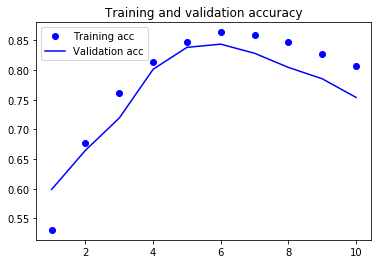

<Figure size 432x288 with 0 Axes>

In [109]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

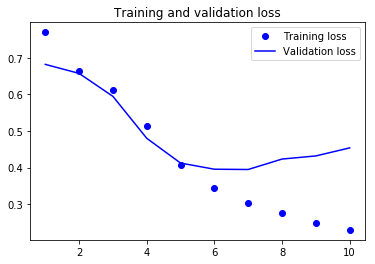

In [110]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [111]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history8 = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s - loss: 0.4106 - val_loss: 0.4379
Epoch 2/20
500/500 [==============================] - 13s - loss: 0.3576 - val_loss: 0.4380
Epoch 3/20
500/500 [==============================] - 12s - loss: 0.3345 - val_loss: 0.4416
Epoch 4/20
500/500 [==============================] - 12s - loss: 0.3203 - val_loss: 0.4355
Epoch 5/20
500/500 [==============================] - 12s - loss: 0.3070 - val_loss: 0.4608
Epoch 6/20
500/500 [==============================] - 13s - loss: 0.2995 - val_loss: 0.4646
Epoch 7/20
500/500 [==============================] - 13s - loss: 0.2898 - val_loss: 0.4575
Epoch 8/20
500/500 [==============================] - 12s - loss: 0.2851 - val_loss: 0.4476
Epoch 9/20
500/500 [==============================] - 13s - loss: 0.2780 - val_loss: 0.4533
Epoch 10/20
500/500 [==============================] - 13s - loss: 0.2714 - val_loss: 0.4503
Epoch 11/20
500/500 [==============================] - 14s - loss: 0.2696 - val

In [112]:
loss, val_loss = pd.Series(history8.history)

In [113]:
epochs = range(1, len(loss) + 1)

In [114]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

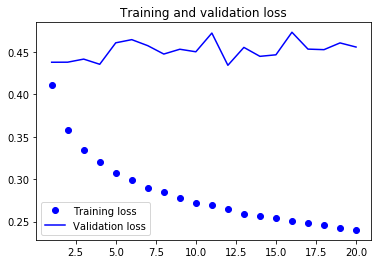

In [115]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [116]:
step = 3
lookback = 720
delay = 144



In [117]:
train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)

In [118]:
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step)

In [119]:
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step)

In [120]:
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [121]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history9 = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 83s - loss: 0.3385 - val_loss: 0.3180
Epoch 2/20
500/500 [==============================] - 82s - loss: 0.3053 - val_loss: 0.2852
Epoch 3/20
500/500 [==============================] - 81s - loss: 0.2903 - val_loss: 0.2850
Epoch 4/20
500/500 [==============================] - 85s - loss: 0.2832 - val_loss: 0.2774
Epoch 5/20
500/500 [==============================] - 85s - loss: 0.2773 - val_loss: 0.2836
Epoch 6/20
500/500 [==============================] - 85s - loss: 0.2707 - val_loss: 0.2855
Epoch 7/20
500/500 [==============================] - 86s - loss: 0.2656 - val_loss: 0.2815
Epoch 8/20
500/500 [==============================] - 84s - loss: 0.2625 - val_loss: 0.2824
Epoch 9/20
500/500 [==============================] - 85s - loss: 0.2572 - val_loss: 0.2979
Epoch 10/20
500/500 [==============================] - 83s - loss: 0.2531 - val_loss: 0.2883
Epoch 11/20
500/500 [==============================] - 84s - loss: 0.2494 - val

In [122]:
loss, val_loss = pd.Series(history9.history)

In [123]:
epochs = range(1, len(loss) + 1)

In [124]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

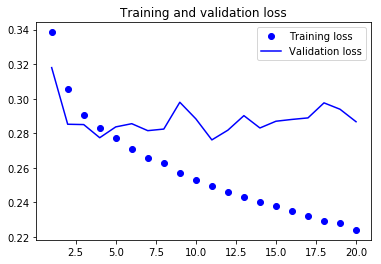

In [125]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()